# SARIMA Base template

> In this notebook we will use **prophet** package to forecast hourly energy use.<br>
> В этом ноутбуке будет разобраны оснонвые работы при работе с временными рядами

In [63]:
# !pip install sidetable
# !pip install statsmodels

In [100]:
import numpy as np
import pandas as pd
import sidetable
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
# Augmented Dickey-Fuller (ADF) test
from statsmodels.tsa.stattools import adfuller
# Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test
from statsmodels.tsa.stattools import kpss
# Box Cox transformation to make variance constant
from scipy.stats import boxcox
# Autocorrelation function (ACF)
from statsmodels.graphics.tsaplots import plot_acf
# Partial autocorrelation function (PACF)
from statsmodels.graphics.tsaplots import plot_pacf
# Seasonal auto regressive integrated moving average (SARIMA)
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pathlib import Path
from datetime import datetime
import warnings
warnings.simplefilter("ignore")
plt.style.use("dark_background")
DATASETS = Path().cwd() / 'data'

## LOAD DATA

In [101]:
df_ts = pd.read_csv(f"{DATASETS}/PJME_hourly.csv.zip", index_col=[0], parse_dates=[0])
df_ts.columns = ['electricity_consumption']
df_ts.info()
df_ts.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 1 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   electricity_consumption  145366 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB


,electricity_consumption
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [102]:
df_ts.stb.missing()

,missing,total,percent
electricity_consumption,0,145366,0.0


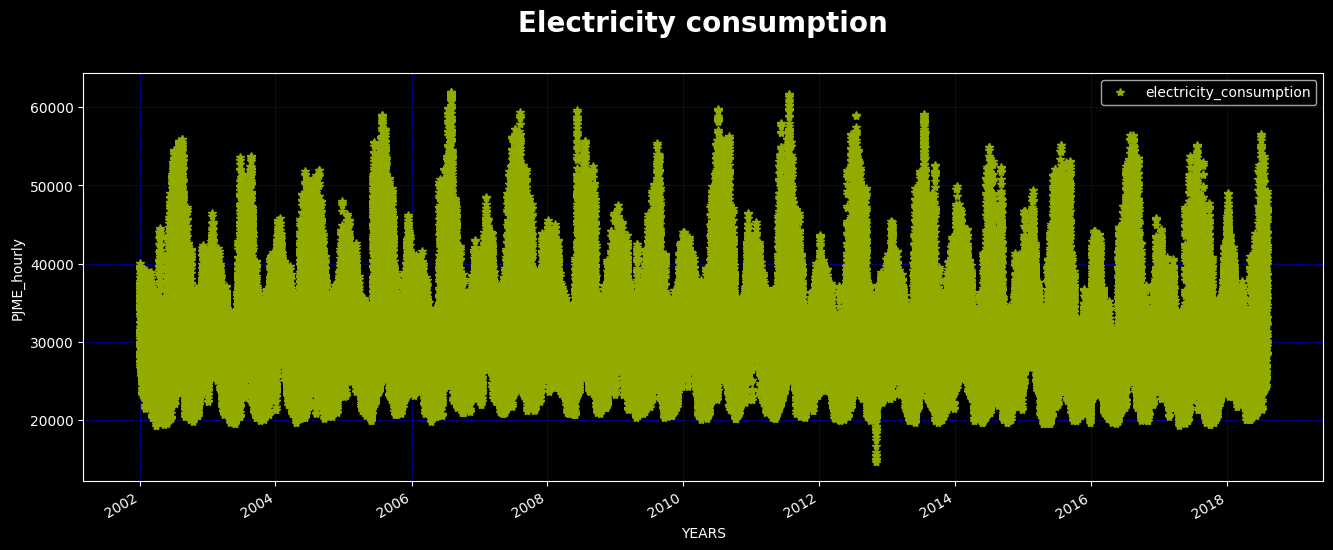

In [4]:
# Plotting
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]
# df_ts.plot(style='*', figsize=(16,6),  title='Electricity consumption')


df_ts.plot(figsize=(16,6), style='*', color=color_pal[2],)
plt.legend(loc='best')
plt.title('Electricity consumption', pad=30, fontdict={'fontsize': 20,
        'fontweight': 'bold'})
plt.grid(color='b', linestyle='--', linewidth=.5)
plt.xlabel('YEARS')
plt.ylabel('PJME_hourly')
plt.show();

## EDA

> We will creat some time series features to see how the trends are impacted by day of week, hour, time of year, etc.<hr>
> Мы создадим некоторые функции временных рядов, чтобы увидеть, как на тенденции влияют день недели, час, время года и т.д.

In [5]:
def create_features(df: pd.DataFrame, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(df_ts, label='electricity_consumption')
features_and_target = pd.concat([X, y], axis=1)

In [6]:
features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,electricity_consumption
Datetime,,,,,,,,,
2002-12-31 01:00:00,1,1,4,12,2002,365,31,1,26498.0
2002-12-31 02:00:00,2,1,4,12,2002,365,31,1,25147.0
2002-12-31 03:00:00,3,1,4,12,2002,365,31,1,24574.0
2002-12-31 04:00:00,4,1,4,12,2002,365,31,1,24393.0
2002-12-31 05:00:00,5,1,4,12,2002,365,31,1,24860.0


## Plotting the Features to see trends

* Power demand has strong daily and seasonal properties.
* Day of week also seems to show differences in peaks

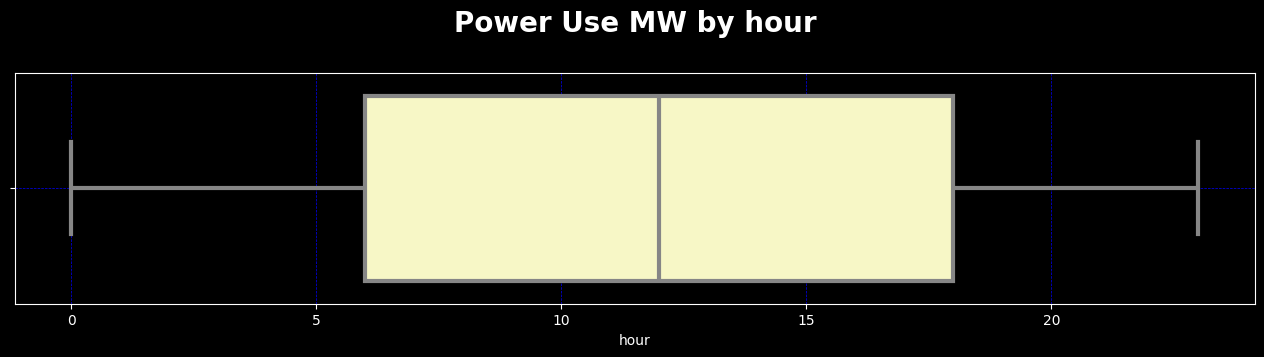

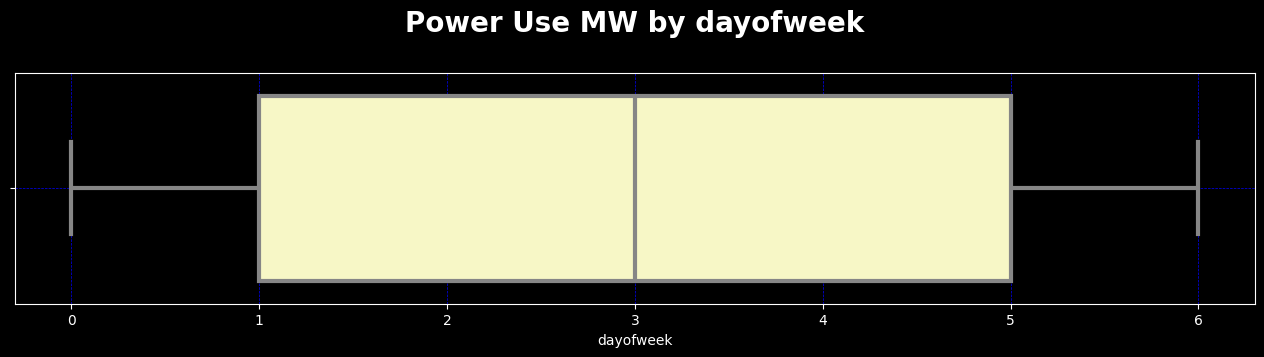

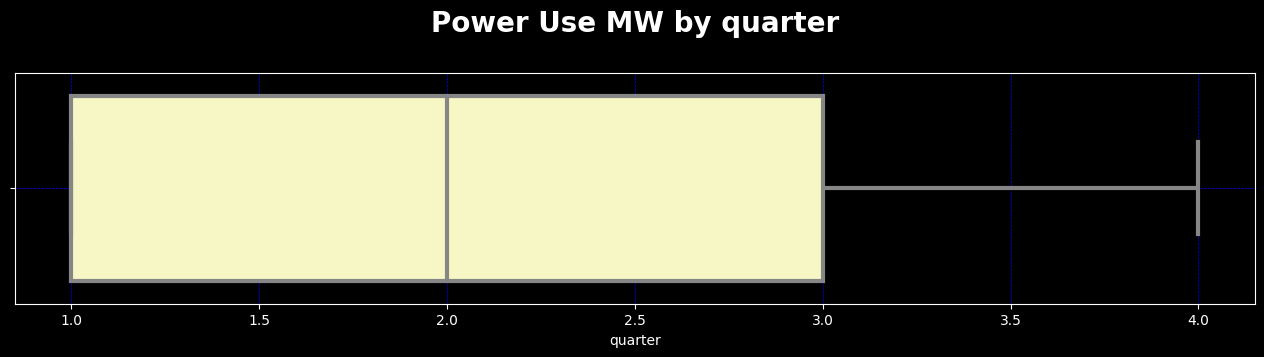

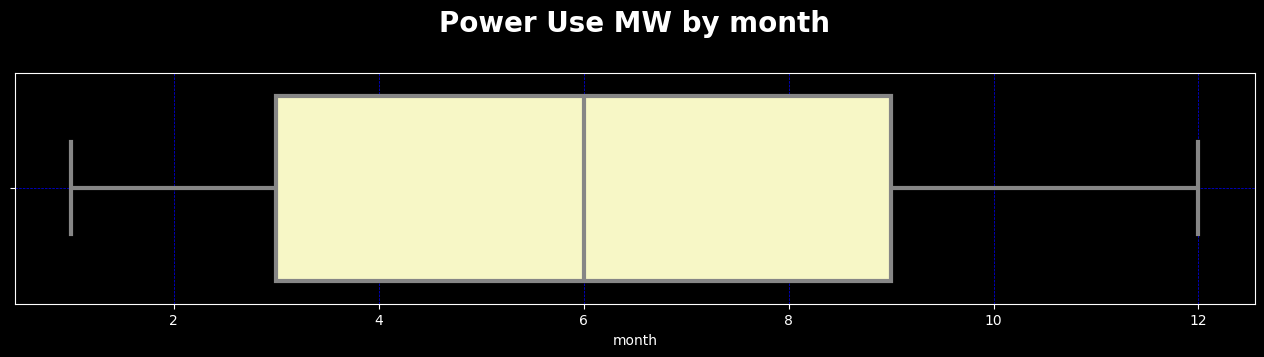

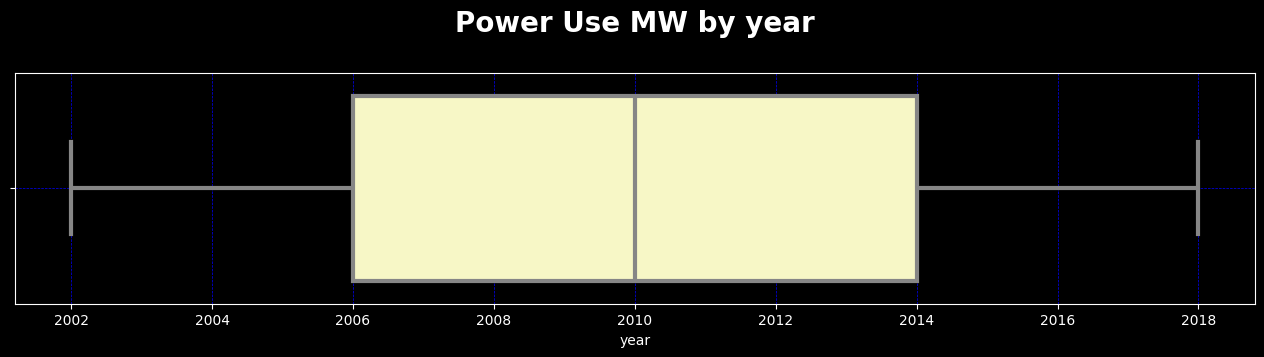

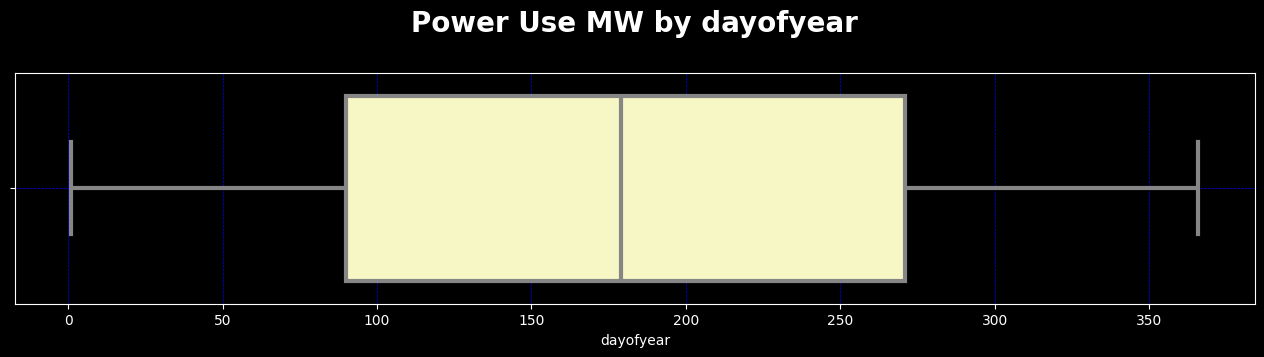

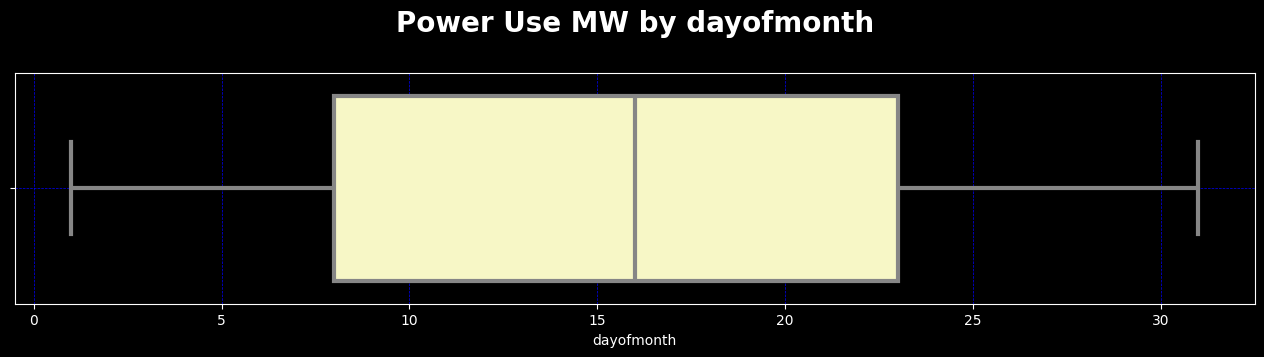

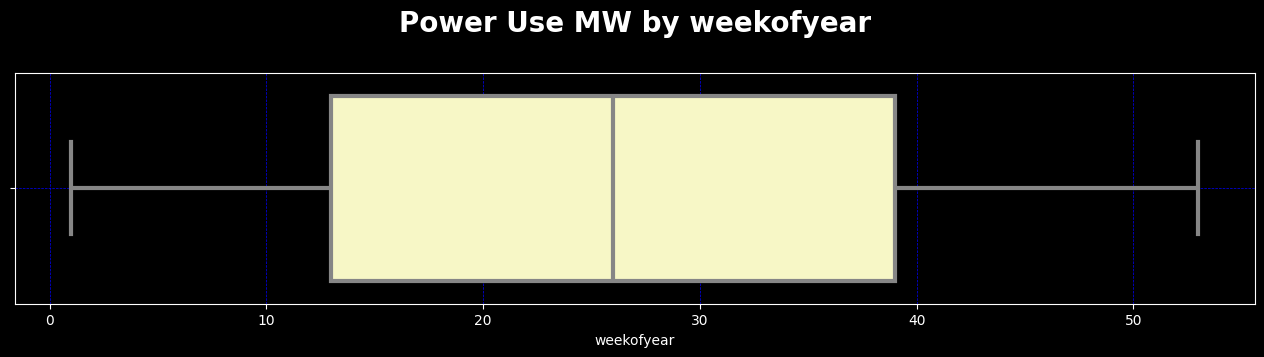

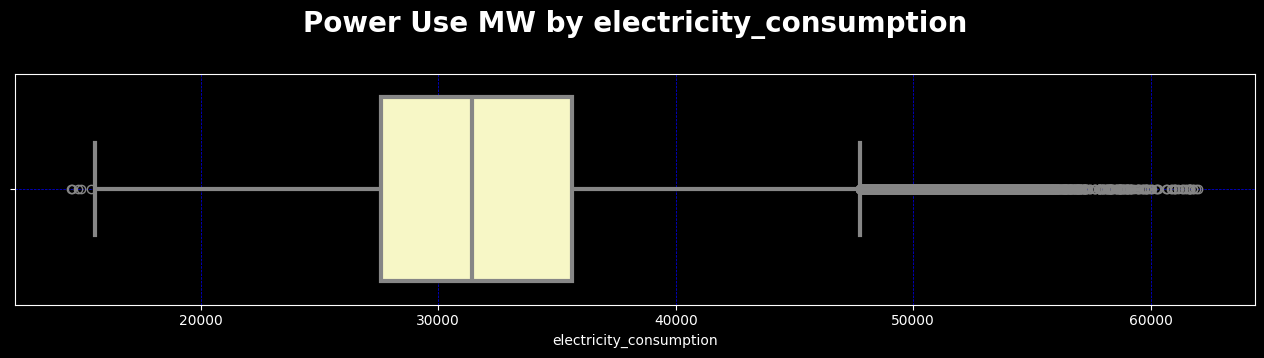

In [7]:
for x in features_and_target.columns:
    plt.figure(figsize=(16,3))
    ax = sns.boxplot(x=features_and_target[f'{x}'], whis=1.5, linewidth=3, palette="Spectral")
    plt.title(f'Power Use MW by {x}', pad=30, fontdict={'fontsize': 20,
        'fontweight': 'bold'})
    plt.grid(color='b', linestyle='--', linewidth=.5)
    plt.show();

## Time series Decomposition
> Additive seasonal decomposition

In [8]:
month_df = df_ts.reset_index().copy()
month_df['Datetime'] = pd.to_datetime(month_df['Datetime'], format='%Y-%m')
month_df = month_df.rename(columns={'Datetime':'Month'}).copy()
month_df.set_index('Month', inplace=True)

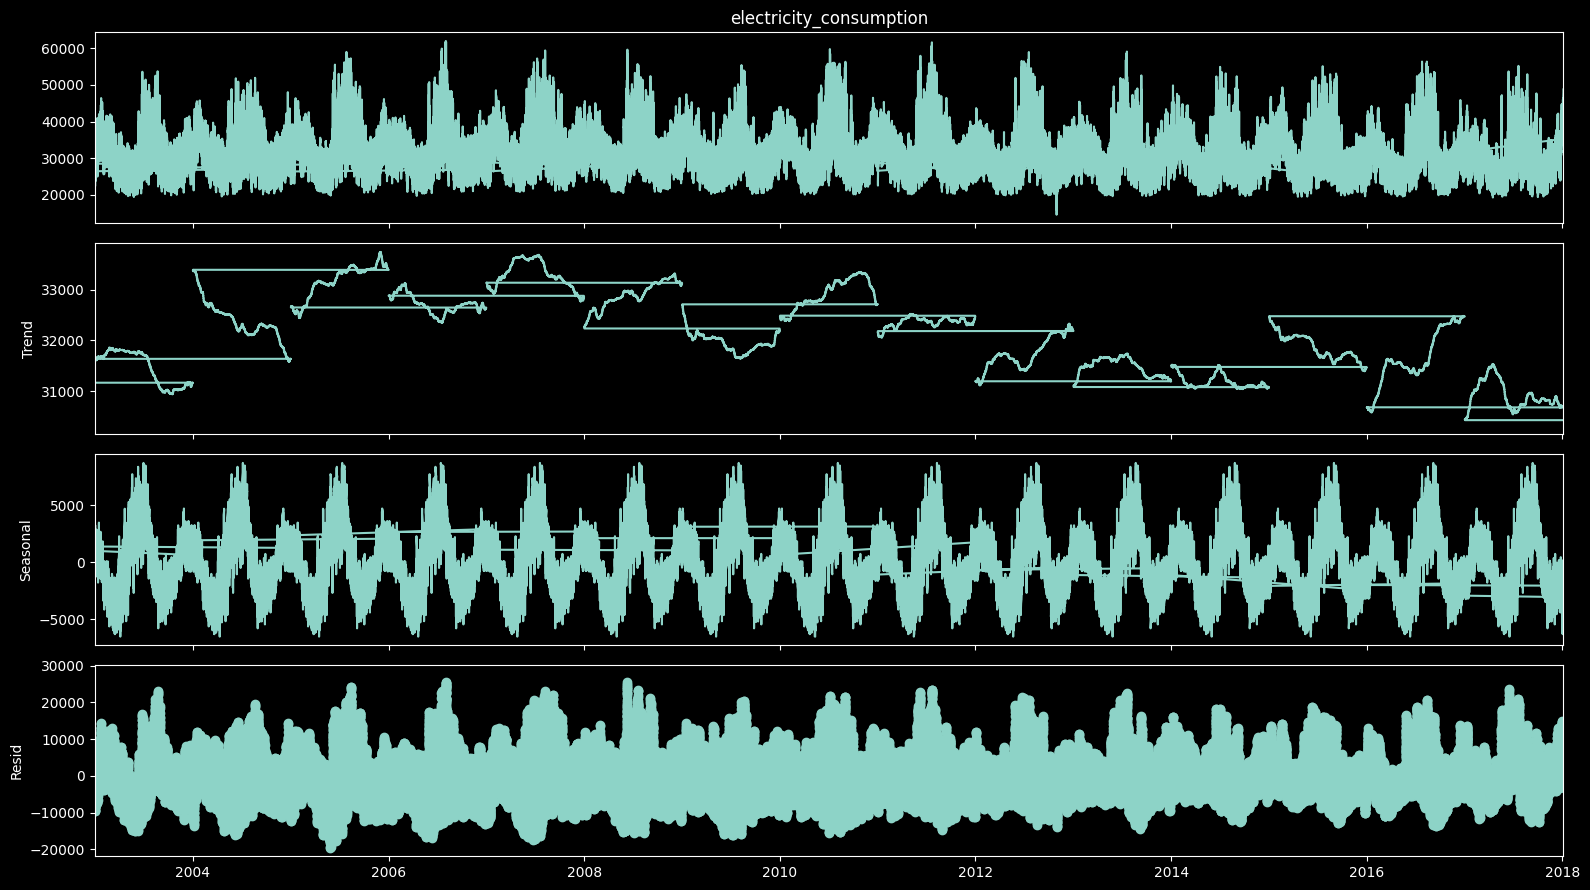

In [9]:
decomposition = sm.tsa.seasonal_decompose(month_df['electricity_consumption'], period=48*180, model='additive') # additive seasonal index
fig = decomposition.plot()
fig.set_size_inches((16, 9))
# Tight layout to realign things
fig.tight_layout()
plt.show();

## Build and evaluate time series forecast
> Split time series data into training and test set

In [10]:
SPLIT_DATE = '01-Jan-2015'
train = df_ts.loc[df_ts.index <= SPLIT_DATE].copy()
test = df_ts.loc[df_ts.index > SPLIT_DATE].copy()

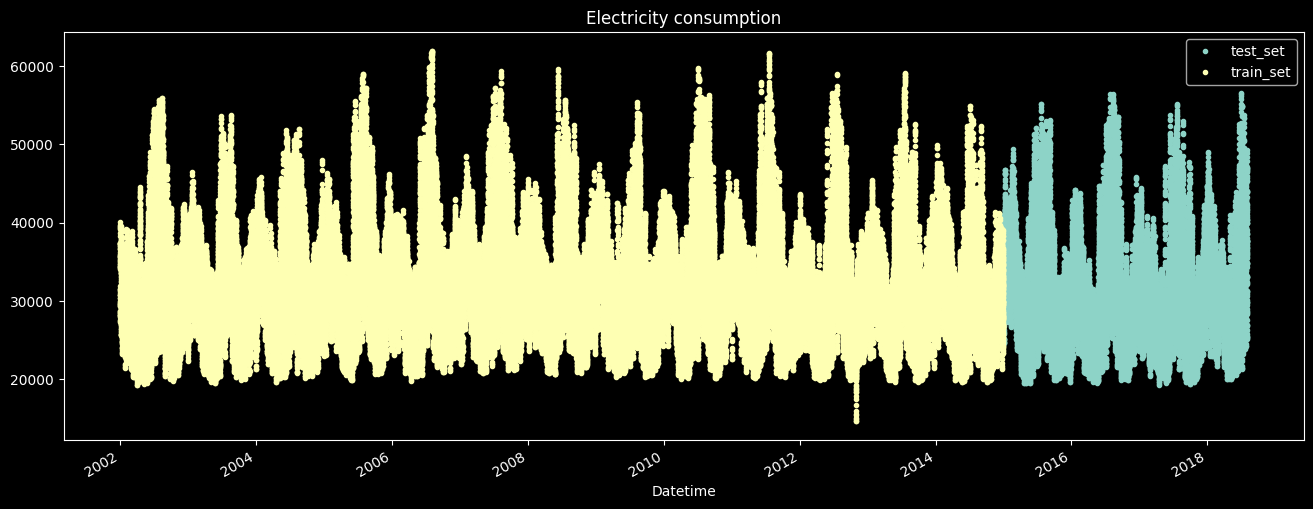

In [11]:
test\
.rename(columns={'electricity_consumption': 'test_set'})\
.join(train.rename(columns={'electricity_consumption': 'train_set'}),
          how='outer') \
.plot(figsize=(16,6), title='Electricity consumption', style='.')
plt.show()

## Auto Regressive methods
> Stationarity vs non-stationary time series

* Augmented **Dickey-Fuller (ADF)** test<br>
[https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/](https://www.machinelearningplus.com/time-series/augmented-dickey-fuller-test/)

In [12]:
adf_test = adfuller(df_ts['electricity_consumption'])
print(f'ADF Statistic: {adf_test[0]:.2}\n'
      f'Critical Values @ 0.05: {adf_test[4]}\n'
      f'p-value: {adf_test[1]:.2}')

ADF Statistic: -1.9e+01
Critical Values @ 0.05: {'1%': -3.430395009088914, '5%': -2.861559893380481, '10%': -2.5667805885384065}
p-value: 2e-30



* **Kwiatkowski-Phillips-Schmidt-Shin (KPSS)** test<br>
[http://www.machinelearning.ru/wiki/index.php?title=%D0%9A%D1%80%D0%B8%D1%82%D0%B5%D1%80%D0%B8%D0%B9_KPSS](http://www.machinelearning.ru/wiki/index.php?title=%D0%9A%D1%80%D0%B8%D1%82%D0%B5%D1%80%D0%B8%D0%B9_KPSS)


In [13]:
kpss_test = kpss(df_ts['electricity_consumption'], store=False, regression='c')

print(f'KPSS Statistic: {kpss_test[0]}\n'
      f'Critical Values @ 0.05: {kpss_test[3]}\n'
     )

KPSS Statistic: 1.1762342370829708
Critical Values @ 0.05: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}



* **Box Cox transformation** to make variance constant<br>
[http://www.machinelearning.ru/wiki/index.php?title=%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%91%D0%BE%D0%BA%D1%81%D0%B0-%D0%9A%D0%BE%D0%BA%D1%81%D0%B0](http://www.machinelearning.ru/wiki/index.php?title=%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%91%D0%BE%D0%BA%D1%81%D0%B0-%D0%9A%D0%BE%D0%BA%D1%81%D0%B0)

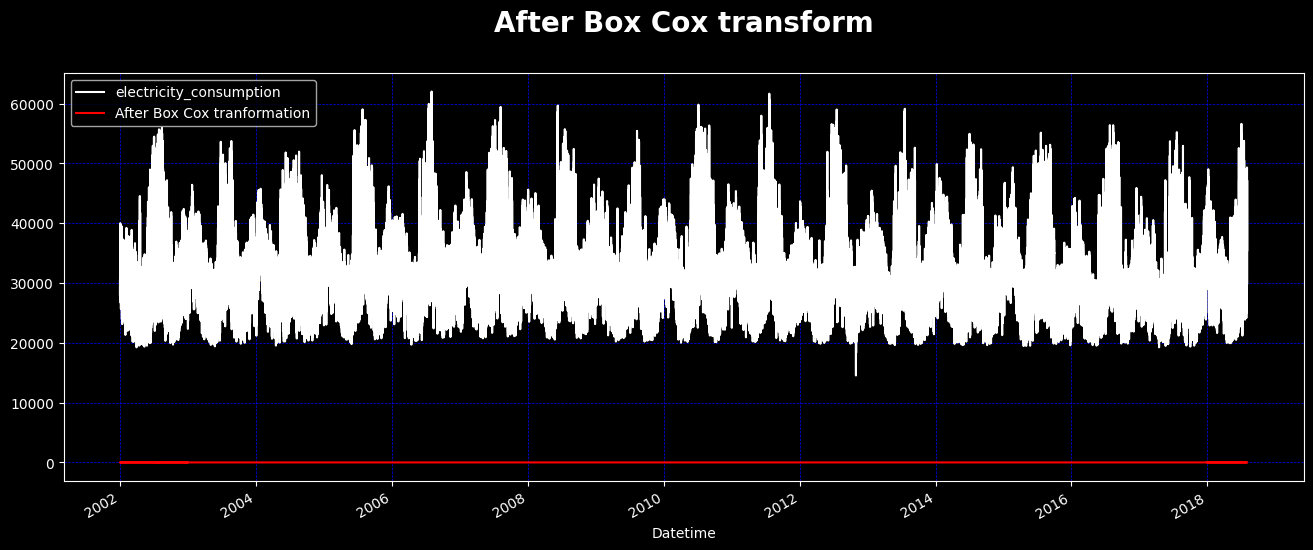

In [14]:
boxcox_df = pd.Series(boxcox(df_ts['electricity_consumption'], lmbda=0), index=df_ts.index)

df_ts['electricity_consumption'].plot(figsize=(16, 6), color='w')
plt.grid(color='b', linestyle='--', linewidth=.5)
plt.plot(boxcox_df, label='After Box Cox tranformation', color='r')
plt.legend(loc='best')
plt.title('After Box Cox transform',
          pad=30, fontdict={'fontsize': 20, 'fontweight': 'bold'})
plt.show();

* Differencing to remove trend

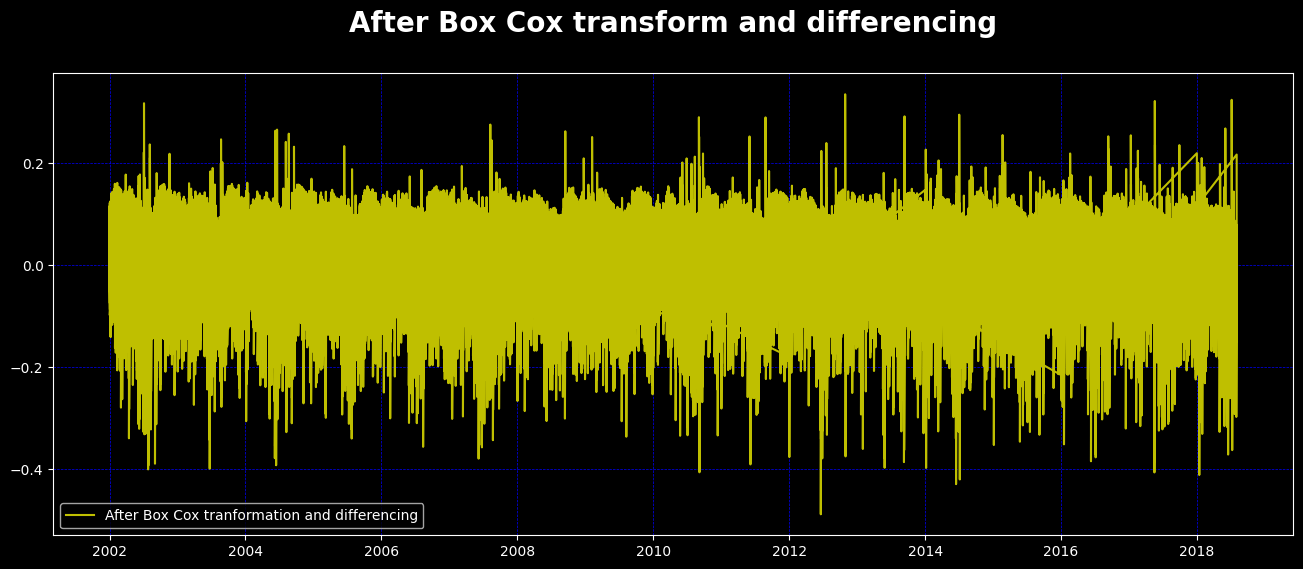

In [15]:
boxcox_diff_df = pd.Series(boxcox_df - boxcox_df.shift(), df_ts.index)
plt.figure(figsize=(16, 6))
plt.grid(color='b', linestyle='--', linewidth=.5)
plt.plot(boxcox_diff_df, label='After Box Cox tranformation and differencing', color='y')
plt.legend(loc='best')
plt.title('After Box Cox transform and differencing', 
          pad=30, fontdict={'fontsize': 20, 'fontweight': 'bold'})
plt.show();

In [16]:
boxcox_diff_df.dropna(inplace=True)

adf_test = adfuller(boxcox_diff_df)
print(f'ADF Statistic: {adf_test[0]:.2}\n'
      f'Critical Values @ 0.05: {adf_test[4]}\n'
      f'p-value: {adf_test[1]:.2}')

ADF Statistic: -5.5e+01
Critical Values @ 0.05: {'1%': -3.4303950093987075, '5%': -2.8615598935174043, '10%': -2.566780588611286}
p-value: 0.0


In [17]:
kpss_test = kpss(boxcox_diff_df)

print(f'KPSS Statistic: {kpss_test[0]}\n'
      f'Critical Values @ 0.05: {kpss_test[3]}\n'
      f'p-value: { kpss_test[1]}'
     )

KPSS Statistic: 0.003974488971904986
Critical Values @ 0.05: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
p-value: 0.1


* Autocorrelation function (ACF)<br>
[https://www.youtube.com/watch?v=I7oS_k9IZkI](https://www.youtube.com/watch?v=I7oS_k9IZkI)


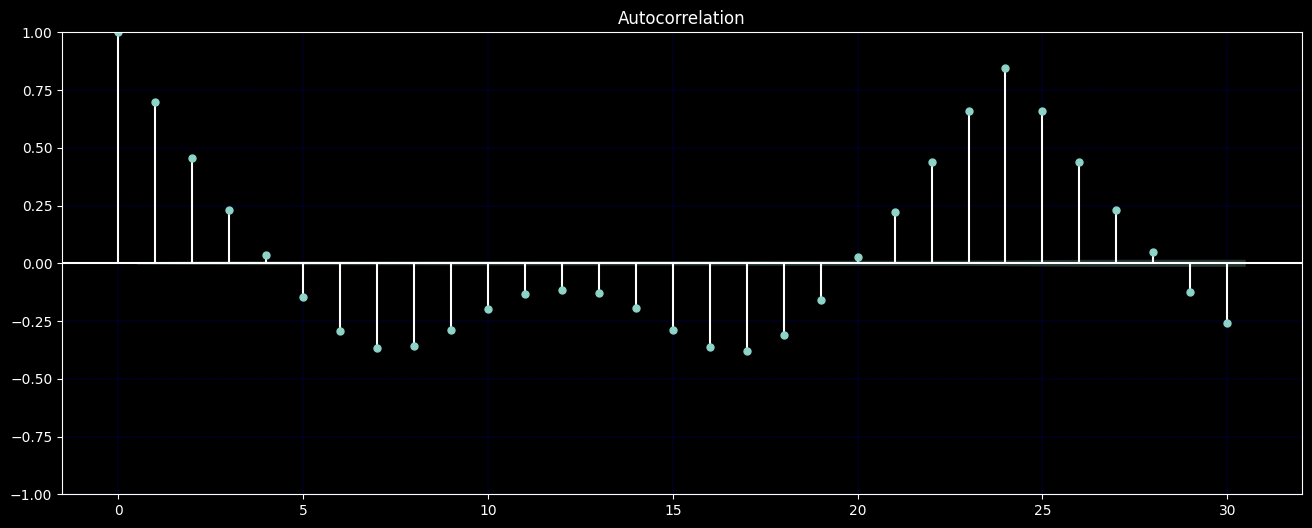

In [18]:
plt.figure(figsize=(16, 6))
plt.grid(color='b', linestyle='--', linewidth=.2)
plot_acf(boxcox_diff_df, ax=plt.gca(), lags=30)
plt.show();

* Partial autocorrelation function (PACF)<br>
[https://online.stat.psu.edu/stat510/lesson/2/2.2](https://online.stat.psu.edu/stat510/lesson/2/2.2)
 

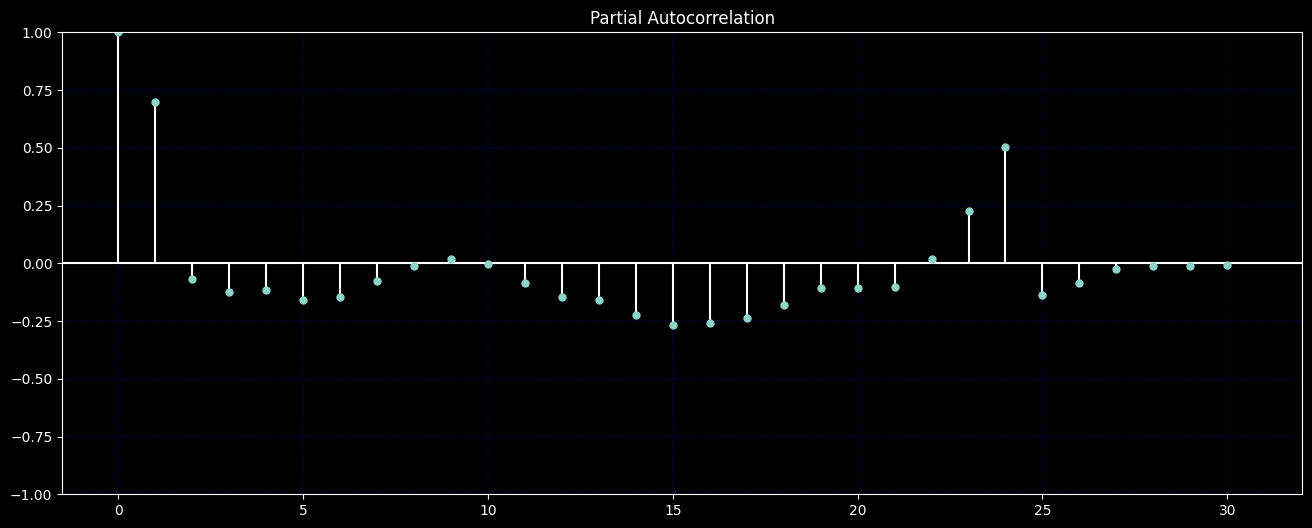

In [19]:
plt.figure(figsize=(16, 6))
plt.grid(color='b', linestyle='--', linewidth=.2)
plot_pacf(boxcox_diff_df, ax=plt.gca(), lags=30)
plt.show();

# Seasonal auto regressive integrated moving average (SARIMA)

In [55]:
INTERVAL = 70000

train_data_boxcox = boxcox_df[:INTERVAL]
test_data_boxcox = boxcox_df[INTERVAL:80_000]

train_data_boxcox_diff = boxcox_diff_df[:INTERVAL-1]
test_data_boxcox_diff = boxcox_diff_df[INTERVAL-1:80_000]

train_data_boxcox_diff[-5:], test_data_boxcox_diff[:5]

(Datetime
 2009-01-05 04:00:00   -0.000228
 2009-01-05 05:00:00    0.026408
 2009-01-05 06:00:00    0.081826
 2009-01-05 07:00:00    0.126783
 2009-01-05 08:00:00    0.065007
 dtype: float64,
 Datetime
 2009-01-05 09:00:00   -0.000423
 2009-01-05 10:00:00    0.000085
 2009-01-05 11:00:00    0.001071
 2009-01-05 12:00:00   -0.007155
 2009-01-05 13:00:00   -0.006920
 dtype: float64)

In [56]:
model = SARIMAX(train_data_boxcox, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)) 
model_fit = model.fit()
print(model_fit.params)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.91450D+00    |proj g|=  1.34476D+01


 This problem is unconstrained.



At iterate    5    f= -2.15432D+00    |proj g|=  8.24726D+00

At iterate   10    f= -2.22667D+00    |proj g|=  5.43871D-02

At iterate   15    f= -2.22673D+00    |proj g|=  4.51124D-01

At iterate   20    f= -2.22785D+00    |proj g|=  4.66483D-01

At iterate   25    f= -2.22790D+00    |proj g|=  7.15125D-02

At iterate   30    f= -2.22987D+00    |proj g|=  1.48749D+00

At iterate   35    f= -2.24038D+00    |proj g|=  1.40667D-01

At iterate   40    f= -2.24040D+00    |proj g|=  9.90652D-03

At iterate   45    f= -2.24051D+00    |proj g|=  2.19259D-01

At iterate   50    f= -2.24144D+00    |proj g|=  1.36106D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

* Recover original time series forecast

In [57]:
test_data_boxcox.index.min(),  test_data_boxcox.index.max()

(Timestamp('2009-01-01 01:00:00'), Timestamp('2012-01-01 00:00:00'))

In [59]:
y_hat_sarima = boxcox_diff_df.copy()
y_hat_sarima['sarima_forecast_boxcox'] = model_fit.predict(start=train_data_boxcox.shape[0], end=(train_data_boxcox.shape[0]+test_data_boxcox.shape[0]-1), dynamic=False)
y_hat_sarima['sarima_forecast'] = np.exp(y_hat_sarima['sarima_forecast_boxcox'])

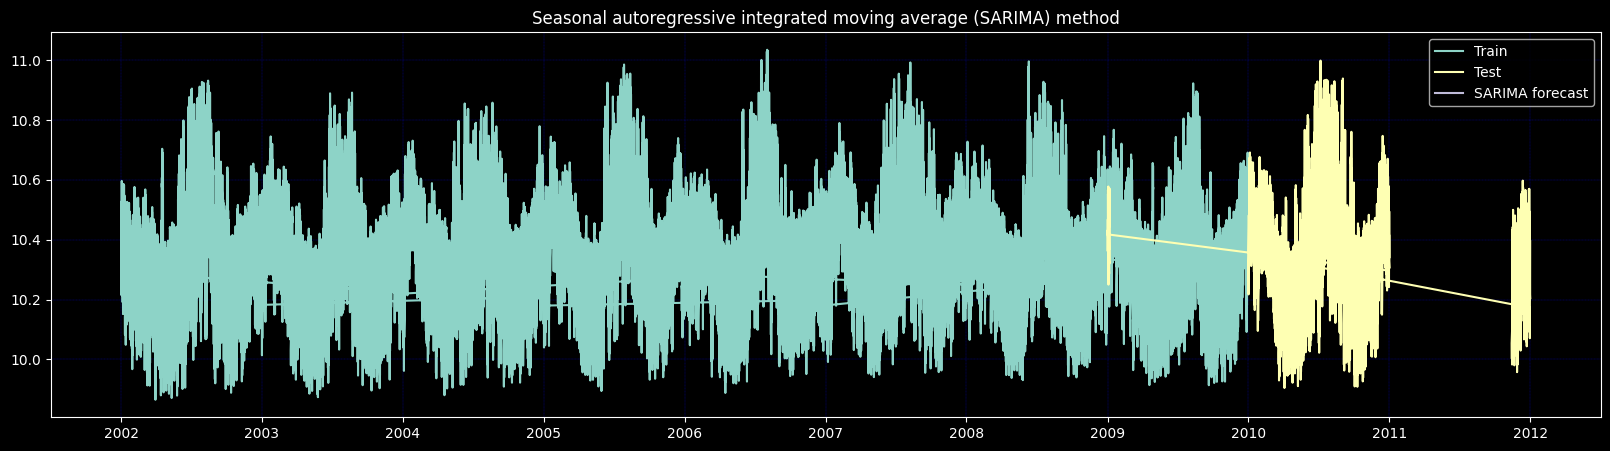

In [99]:
plt.figure(figsize=(20,5))
plt.grid(color='b', linestyle='--', linewidth=.2)
plt.plot(train_data_boxcox, label='Train')
plt.plot(test_data_boxcox, label='Test')
plt.plot(y_hat_sarima['sarima_forecast_boxcox'][test_data_boxcox.shape[0]:], label='SARIMA forecast')
plt.legend(loc='best')
plt.title('Seasonal autoregressive integrated moving average (SARIMA) method')
plt.show()

In [98]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test_data_boxcox, y_hat_sarima['sarima_forecast'][:10000])).round(2)
mape = np.round(np.mean(np.abs(test_data_boxcox.values - y_hat_sarima['sarima_forecast'][:10000]) / test_data_boxcox.values)*100,2)

results = pd.DataFrame({'Method':['Seasonal autoregressive integrated moving average (SARIMA) method'], 'RMSE': [rmse],'MAPE': [mape] })

results = results[['Method', 'RMSE', 'MAPE']]
results

,Method,RMSE,MAPE
0,Seasonal autoregressive integrated moving aver...,5357.41,16141.13


<hr>